# Solving the MAX-CUT  problem using QAOA
***

Author: **Aneta Baloyan**
***

In this jupyter notebook I present a simple implementation of the QAOA algorithm for the MAX-CUT problem on weighted graphs, using IBM's QisKit platform. I used the implementation of the same problem on unweighted graphs as a base, and changed the optimization step such that the cost function took the edge weights into account.

***
## Quick summary of the QAOA algorithm

Let us summarize the steps of the QAOA algorithm for the MAX-CUT problem as described in \[1\]. Here, we do not impose a limitation on the graphs to be bounded in degree (i.e. nodes are allowed to have arbitrary number of edges, not bounded from above). 

In the MAX-CUT problem we are given a graph, and asked to partition it into two sets of nodes, such that the number of edges crossing between the two sets is maximal for the given graph. The QAOA algorithm is a quantum-classical hybrid algorithm to approximately find the max cut of a given graph. Here are the steps of the QAOA algorithm for the max cut problem
1. For a graph of $n$ nodes create a quantum circuit with $n$ qubits. Each qubit represents a node in the graph. The states $\vert 0\rangle$ and $\vert 1\rangle$ for a qubit distinguish the set to which the corresponding node belongs to. A bit-string encoded into the qubits represents a partition of the graph.
2. Apply Hadamard gates to all qubits to obtain the state $$\vert s\rangle = \frac{1}{\sqrt{2^{n}}}\sum_{z\in \{0, 1\}^n} \vert z\rangle $$ which is basically the uniform superposition of all possible partitions of the graph into two sets. Now we need to find from this superposition the state(s) which have maximum possible crossing edges for the given graph.
3. Define the following operators $$ \hat{C} = \sum_{\langle ij\rangle \in edges}\hat{C}_{\langle ij\rangle} $$ $$ \hat{B} = \sum_{i=0}^{N}\hat{\sigma}_i^x $$ where $\hat{\sigma}_i^x$ is the Pauli $X$ matrix for the $i$-th qubit, the summation on the first line is over all edges in the graph, $\hat{C}_{\langle ij\rangle}$ has eigenvalues 0 and 1 in the computational basis and for edge $\langle ij\rangle$ is defined as $\hat{C}_{\langle ij\rangle} = \frac{1}{2}(1 - \hat{\sigma}^z_i\hat{\sigma}^z_j)$. The operator $\hat{C}_{\langle ij\rangle}$ has eigenvalue $1$ when it acts on a bit string where the edge $\langle ij\rangle$ has the endpoints in different sets, and $0$ otherwise. Based on these operators define the following unitary tranformations $$ U(C, a) = e^{-ia \hat{C}} $$ $$ U(B, b) = e^{-ib \hat{B}} $$ where $b$ is a real number in the interval $[0, \pi]$, and $a$ is a real number in the interval $[0,2\pi]$. For an integer $p \geq 1$ and two parameter vectors $\beta$ and $\gamma$ of lenght $p$, apply the following unitary transformation on the state prepared in step 2 $$ U(B, \beta_{p-1})U(C, \gamma_{p-1}) \dots U(B, \beta_0)U(C, \gamma_0) $$ to obtain the state $$ \vert \beta, \gamma\rangle = U(B, \beta_{p-1})U(C, \gamma_{p-1}) \dots U(B, \beta_0)U(C, \gamma_0)\vert s\rangle $$
4. Start with some initial guess for $\beta$ and $\gamma$, and with a classical optimization procedure find optimal values for the paramteres $\beta$ and $\gamma$ for which the state $\vert \beta, \gamma\rangle$ yields maximal expectation value for the operator $\hat{C}$. The cost function for the classical optimization will be the expectation value of $\hat{C}$ in the state $\vert \beta, \gamma\rangle$. The procedure looks like this: 
    - for given $p$ choose some initial $\beta$ and $\gamma$. The larger $p$ is the larger is the accuracy of the algorithm, but heavier is the classical optimizaiton part, so $p$ should be chosen heuristically with this considerations in mind.
    - construct a quantum circuit with given parameters $\beta$ and $\gamma$ and measure the expectation value of $\hat{C}$
    - with classical optimization procedure guess better values for $\beta$ and $\gamma$ to make the expectation value of $\hat{C}$ larger
    - repeat the previous two substeps until you reach a maximum
    
***

## Implementation

Let's first import all the modules and functions needed for this notebook. 

In [1]:
import networkx as nx
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram
from scipy.optimize import minimize
import numpy as np
import random
import time

Generate an Erdős–Rényi random graph with random uniform weights and draw it.

In [2]:
node_count = 7
edge_prob = 0.6
colors = ['salmon', 'lightblue']
np.random.seed(42) # fix the seed for reproducibility 
random.seed(42)

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


{(0, 1): Text(5.0, 2.5, '0.95'),
 (0, 3): Text(6.0, 1.0, '0.06'),
 (0, 5): Text(5.5, 5.0, '0.3'),
 (1, 2): Text(1.5, 3.5, '0.16'),
 (1, 4): Text(5.0, 6.0, '0.97'),
 (1, 5): Text(0.5, 6.5, '0.43'),
 (1, 6): Text(3.0, 2.0, '0.51'),
 (2, 5): Text(2.0, 6.0, '0.61'),
 (2, 6): Text(4.5, 1.5, '0.05'),
 (3, 4): Text(6.0, 4.5, '0.18'),
 (3, 5): Text(1.5, 5.0, '0.29'),
 (4, 5): Text(5.5, 8.5, '0.46'),
 (4, 6): Text(8.0, 4.0, '0.07')}

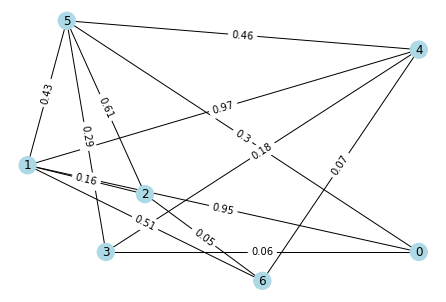

In [3]:
G = nx.Graph()
up_to_now = 0
for i in range(node_count):
    G.add_node(i, pos=(random.randint(0,10), random.randint(0,10)))
    for j in range(up_to_now):
        if np.random.uniform() <= edge_prob: 
            G.add_edge(i, j, weight=np.round(np.random.uniform(), 2))
    up_to_now += 1

edge_count = G.number_of_edges()

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_color=[colors[i] for i in np.ones(len(G.nodes)).astype('int')], with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [4]:
G.__dict__ # check that all the attributes are set correctly

{'graph_attr_dict_factory': dict,
 'node_dict_factory': dict,
 'node_attr_dict_factory': dict,
 'adjlist_outer_dict_factory': dict,
 'adjlist_inner_dict_factory': dict,
 'edge_attr_dict_factory': dict,
 'graph': {},
 '_node': {0: {'pos': (10, 1)},
  1: {'pos': (0, 4)},
  2: {'pos': (3, 3)},
  3: {'pos': (2, 1)},
  4: {'pos': (10, 8)},
  5: {'pos': (1, 9)},
  6: {'pos': (6, 0)}},
 '_adj': {0: {1: {'weight': 0.95}, 3: {'weight': 0.06}, 5: {'weight': 0.3}},
  1: {0: {'weight': 0.95},
   2: {'weight': 0.16},
   4: {'weight': 0.97},
   5: {'weight': 0.43},
   6: {'weight': 0.51}},
  2: {1: {'weight': 0.16}, 5: {'weight': 0.61}, 6: {'weight': 0.05}},
  3: {0: {'weight': 0.06}, 4: {'weight': 0.18}, 5: {'weight': 0.29}},
  4: {1: {'weight': 0.97},
   3: {'weight': 0.18},
   5: {'weight': 0.46},
   6: {'weight': 0.07}},
  5: {0: {'weight': 0.3},
   1: {'weight': 0.43},
   2: {'weight': 0.61},
   3: {'weight': 0.29},
   4: {'weight': 0.46}},
  6: {1: {'weight': 0.51}, 2: {'weight': 0.05}, 4: {'w

Now we define a function to construct and return a QAOA circuit for a given graph and vectors $\beta$ and $\gamma$. Note, that the matrix representation of the unitary operator $U(\hat{C}_{\langle ij\rangle}, a)$ is 
$$ \left( \begin{matrix}1 & 0 & 0 & 0 \\ 0 & e^{-ia} & 0 & 0 \\ 0 & 0 & e^{-ia} & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$$ 
which can be implemented with a combination of `u1` and `cu1` gates from the QisKit library as seen in the code below. The action of the $\hat{B}$ operator can be implemented with `rx` gates.

In [5]:
def get_qaoa_circuit(graph, beta, gamma):
    """
    Construct and return the QAOA circuit.
    Args:
        graph (nx.Graph): The graph
        beta (ndarray): The optimization parameters beta.
        gamma (ndarray): The optimization parameters gamma.
        
    Returns:
        QuantumCircuit: The circuit    
    """
    
    if(len(beta) != len(gamma)):
        raise ValueError("beta and gamma should be lists of same size")
    
    nodes = graph.number_of_nodes()
    qreg = QuantumRegister(nodes)
    creg = ClassicalRegister(nodes)
    qc = QuantumCircuit(qreg, creg)

    qc.h(qreg)

    for p in range(len(beta)):
        qc.barrier()
        for (i, k) in graph.edges:
            qc.cu1(2*gamma[p], qreg[i], qreg[k])
            qc.u1(-gamma[p], qreg[i])
            qc.u1(-gamma[p], qreg[k])
        
        qc.barrier()
        qc.rx(2*beta[p], qreg)
       
    qc.barrier()
    qc.measure(qreg, creg[::-1])
            
    return qc

For the classical optimization part we will use the `minimize` function from `scipy.optimize`, hence we will define the cost function as the expectation value of $\hat{C}$ with a minus sign, so that we search for a minimum, not a maximum. The nice thing about the operator $\hat{C}$ is that it is diagonal in the computational basis, thus its expectation value in some state $\vert \beta, \gamma \rangle$ can be calculated as follows:
- sample the state $\vert \beta, \gamma \rangle$ in the computational basis
- calculate the expectation value of $\hat{C}$ with the following fromula $$ \langle \gamma, \beta\vert \hat{C} \vert \beta, \gamma \rangle = \sum_{z\in \{0, 1\}^n}C(z)\vert \langle z\vert \beta, \gamma \rangle \vert^2 $$ where $C(z)$ is the eigenvalue of the operator $\hat{C}$ when applied to the computational basis bitstring $z$ (it is basically the sum of the weights of the edges that are on the cut corresponding to a given bitstring).

After sampling a quantum state enough times we feed the sampling counts to the function defined below, which returns the cost function as described above.

We additionally define a wrapper function over the cost function as well, which does two things
1. Accepts the parameters $\beta$ and $\gamma$ as one list being the concatenation of the vectors $\beta$ and $\gamma$. This is done for further convenience to be used in the `scipy.optimize.minimize`
2. Gathers all the actions for cost calculation in one place, i.e. for given set of parameters and number $p$ it constructs the corresponding quantum circuit, does the sampling, calculates the cost. The quantum circuit will be executed on the 'qasm_simulator' backend. We could have used a 'statevector_simulator' instead, and get the output distribution right away, without sampling, but we have chosen not to do it, since it does not mimic what will happen if the algorithm is executed on a real quantum computer.

In [6]:
def cost_function(graph, shots, counts):
    """
    Calculate and return the cost based on given sampling counts.
    
    Args:
        graph (nx.Graph): The graph
        shots (int): Number of samples taken
        counts (dict): Occurence counts of each bit-string in the sampling event
        
    Returns:
        float: The cost
    """
    cost = 0
    for (x, count) in counts.items():
        c = 0
        # count the number of crossing edges
        for (i, k) in graph.edges:
            try:
                w = graph._adj[i][k]['weight']
            except:
                w = 1
                
            if(x[i] != x[k]):
                c += w
        cost += c * count / shots
        
    return -cost

def cost_wrapper(params, graph, shots=1000):
    """
    Construct QAOA circuit, sample it, calculate and return the cost.
    Args:
        params (ndarray): The optimization parameters beta and gamma concatenated in one list
        graph (nx.Graph): The graph
        shots (dict): Number of shots do be done during sampling
        
    Returns:
        float: The cost    
    """
    params_count = len(params)
    if params_count % 2 != 0:
        raise ValueError("Even number of parameters should be provided, the first half being the parameters beta, and the second half being gamma")
    beta = params[:params_count//2]
    gamma = params[params_count//2:]
    qaoa_qc = get_qaoa_circuit(graph, beta, gamma)

    backend = Aer.get_backend("qasm_simulator")
    job = execute(qaoa_qc, backend, shots=shots )
    results = job.result()
    
    return cost_function(graph, shots, results.get_counts())

OK, now we have all the necessary functions for QAOA. For the classical optimization we just need to provide a starting point for the parameters $\beta$ and $\gamma$. We can provide some constant or random starting point. However, the QAOA cost function for the MAX-CUT problem is not convex, and it tends to have a bunch of local minimums. In an attempt to avoid local minimums with smallest costs, and find minimums with larger costs or, better yet, the global minimum we employ the following strategy: for a given graph check 100 random sets of the parameters, and pick the one with the lowest cost, then use these values as starting point for the classical optimization. 

In [7]:
def get_random_start(graph, p):
    beta = np.linspace(0, np.pi, 5)
    gamma = np.linspace(0, 2*np.pi, 10)
    
    min_cost = cost_wrapper(np.zeros(2*p), graph)
    min_beta = np.zeros(p)
    min_gamma = np.zeros(p)
    for _ in range(100):
        b = np.random.uniform(0, np.pi, p)
        g = np.random.uniform(0, 2*np.pi, p)
        cost = cost_wrapper(np.append(b, g), graph)
        if cost < min_cost:
            min_cost = cost
            min_beta = b
            min_gamma = g
    
    return np.concatenate((min_beta, min_gamma))

Now let us run everything we have prepared so far for $p=20$ and the random graph generated in the beginning of the notebook.

In [9]:
p = 20 # take p = 20 for accuracy, this will increase execution time

starting_params = get_random_start(G, p)
startTime = time.time()
optimal_params = minimize(cost_wrapper, starting_params, G, method='COBYLA')['x']
executionTime = (time.time() - startTime)
print(f'Execution time: {executionTime}s')

beta = optimal_params[:len(optimal_params)//2]
gamma = optimal_params[len(optimal_params)//2:]

Execution time: 86.404865026474s


Let us run the quantum circuit with the optimal parameters and see how does the output look like. The histogram below shows, that there are clearly highlighted states with high probability.

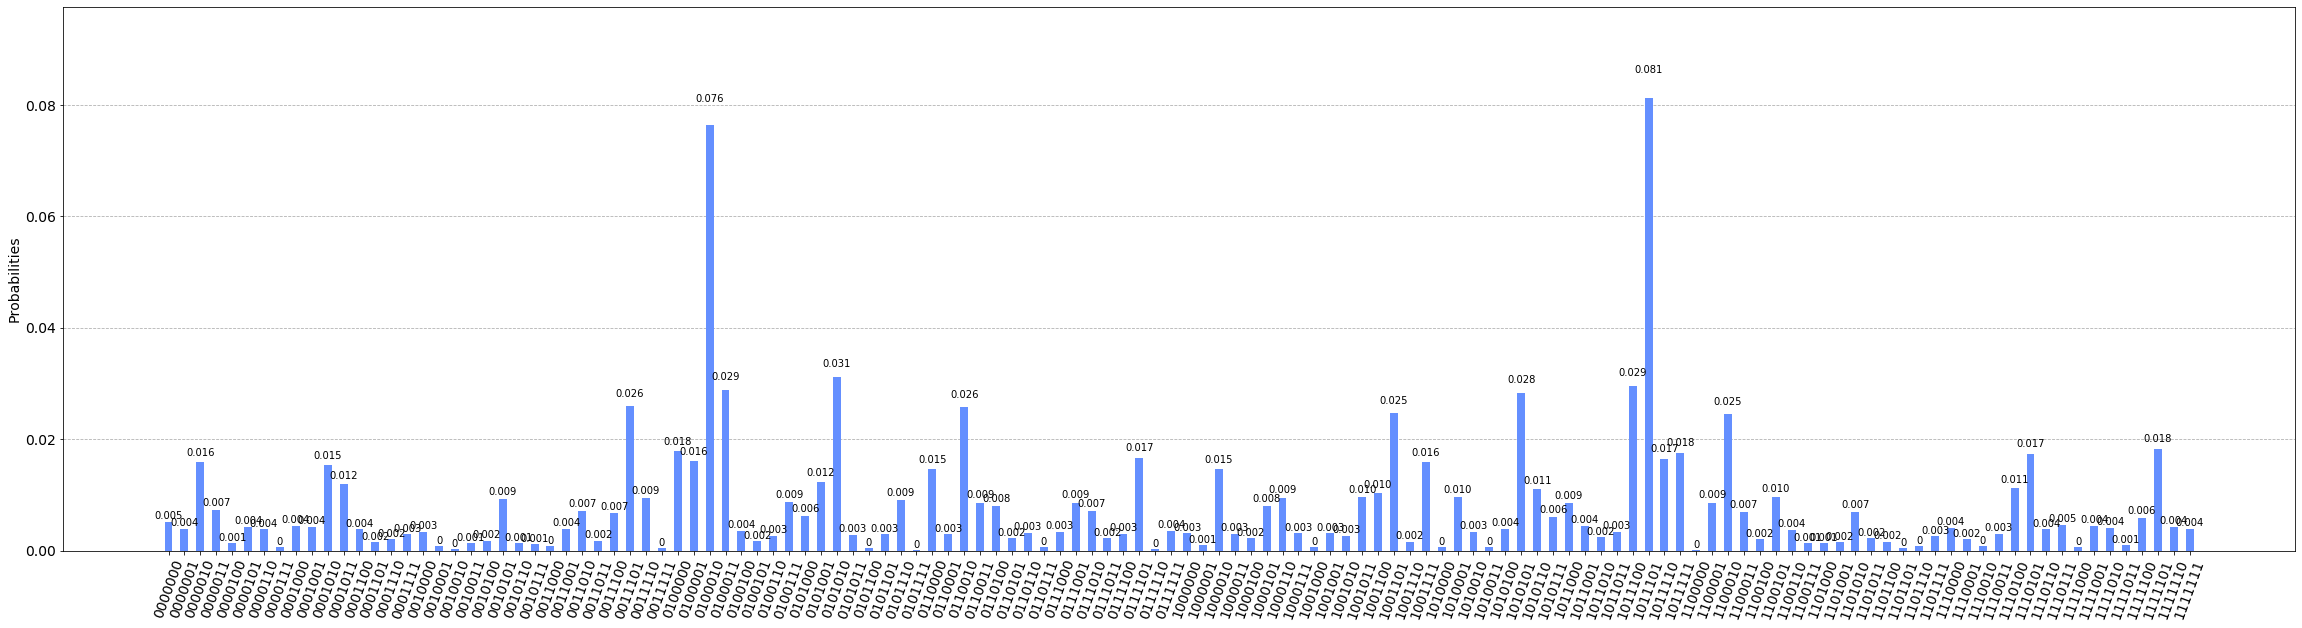

In [10]:
qc = get_qaoa_circuit(G, beta, gamma)

backend = Aer.get_backend("qasm_simulator")
job = execute(qc, backend, shots=10000)
results = job.result()
counts = results.get_counts()
plot_histogram(counts, figsize=(40, 10))

Let's get the size of the cuts for the top 10 bitstrings with highest probability.

In [11]:
counts_sorted = sorted(counts.items(), key=lambda item: item[1], reverse=True)
counts_top = counts_sorted[0:10]

edges = list(G.edges)

print(f'In a graph of {node_count} nodes and {edge_count} edges, we found a cut of...\n')
for (x, count) in counts_top:
    # get one of the partitions
    partition = [i for i, s in enumerate(x) if s == '1']
    cut_size = nx.algorithms.cuts.cut_size(G, partition)
    w = np.round(np.sum([G._adj[e[0]][e[1]]['weight'] for e in edges if x[e[0]] != x[e[1]]]), 2)
    
    print(f'\t>>>> Size {cut_size} and total weight of {w}: {x}')

In a graph of 7 nodes and 13 edges, we found a cut of...

	>>>> Size 8 and total weight of 4.25: 1011101
	>>>> Size 8 and total weight of 4.25: 0100010
	>>>> Size 9 and total weight of 4.2: 0101010
	>>>> Size 9 and total weight of 3.86: 1011100
	>>>> Size 9 and total weight of 3.86: 0100011
	>>>> Size 9 and total weight of 4.2: 1010101
	>>>> Size 7 and total weight of 3.06: 0011101
	>>>> Size 7 and total weight of 3.53: 0110010
	>>>> Size 7 and total weight of 3.53: 1001101
	>>>> Size 7 and total weight of 3.06: 1100010


{(0, 1): Text(5.0, 2.5, '0.95'),
 (0, 3): Text(6.0, 1.0, '0.06'),
 (0, 5): Text(5.5, 5.0, '0.3'),
 (1, 2): Text(1.5, 3.5, '0.16'),
 (1, 4): Text(5.0, 6.0, '0.97'),
 (1, 5): Text(0.5, 6.5, '0.43'),
 (1, 6): Text(3.0, 2.0, '0.51'),
 (2, 5): Text(2.0, 6.0, '0.61'),
 (2, 6): Text(4.5, 1.5, '0.05'),
 (3, 4): Text(6.0, 4.5, '0.18'),
 (3, 5): Text(1.5, 5.0, '0.29'),
 (4, 5): Text(5.5, 8.5, '0.46'),
 (4, 6): Text(8.0, 4.0, '0.07')}

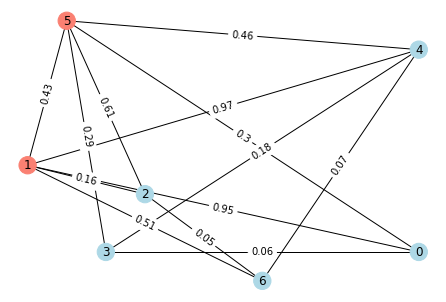

In [12]:
x = counts_top[0][0]
nx.draw(G, pos, node_color=[colors[int(i)] for i in x], with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# References #
\[1\] Edward Farhi, Jeffrey Goldstone, Sam Gutmann, "A Quantum Approximate Optimization Algorithm", [arXiv:1411.4028](https://arxiv.org/abs/1411.4028v1)